# A Naive Kmeans Implementation with Numpy and Pandas.

In [1]:
import pandas as pd
import numpy as np

In [104]:
class NaiveKmeans:
    """This is a naive implementation of the KMeans algorithm for clustering"""

    def __init__(self, df, k, max_iterations=100):
        """Instantiate class attributes"""
        self.df = df.copy()
        self.k = k
        self.max_iterations = max_iterations
        self.centroids, self.centroid_coordinates = self.get_centroids(self.df, self.k)
        self.n_iterations = 0
        self.df_columns = self.df.columns

    def get_centroids(self, df, k):
        """Initializes the random centroids and their coordinates"""
        for col in df.columns:
            if df[col].dtype == "object":
                raise Exception(f"All columns must have numeric datatypes. {col} is a string.")
        centroids = df.sample(k)
        centroid_coordinates = centroids.values.tolist()
        return centroids, centroid_coordinates
    
    def calculate_distances(self):
        """
            Takes in the coordinates and calculate the euclidean 
            distances btwn the each centroid and the datapoints
        """
        distances_columns = []
        for i, coordinates in enumerate(self.centroid_coordinates):
            name = f"distances_{i+1}"
            distance_difference = (self.df[self.df_columns] - coordinates)**2
            distance_sum = distance_difference.sum(axis=1)
            distances_sqrt = np.sqrt(distance_sum)
            self.df[name] = distances_sqrt
            distances_columns.append(name)
        return distances_columns
    
    def calculate_clusters(self):
        """Calculates the clusters each record belongs to"""
        distance_cols = self.calculate_distances()
        self.df["clusters"] = self.df[distance_cols].idxmin(axis=1).str.split("_").str[-1]
    
    def adjust_centroids(self):
        """Adjusts the centroids by calculating the means for the clusters"""
        self.calculate_clusters()
        new_centroids = round(self.df.groupby("clusters")[self.df_columns].mean(), 2)
        new_coords = new_centroids.values.tolist()
        return new_centroids, new_coords
    
    def predict(self):
        """
            Iterates the adjustments of the centroids until convergence or until 
            the set number of iterations is reached.
        """
        for i in range(self.max_iterations):
            previous_coordinates = self.centroid_coordinates
            self.centroids, self.centroid_coordinates = self.adjust_centroids()
            if previous_coordinates == self.centroid_coordinates:
                break
        self.n_iterations = i+1
        return self.df["clusters"]
    
    def inertia(self):
        """Calculates the distance between each datapoint and the centroid of its cluster"""
        if "clusters" in self.df.columns:
            final_df = self.df.copy()
            non_distance_cols = self.df_columns.tolist()
            final_df = final_df.drop(non_distance_cols, axis=1)
            final_df = final_df.drop("clusters", axis=1)
            final_df["square_distance"] = final_df.min(axis=1) ** 2
            return round(final_df["square_distance"].sum())
        else:
            raise Exception("Run the predict method first to cluster your data")

## Test the Algorithm with Data

In [105]:
df = pd.read_csv("./mall_customers.csv")
df = df.rename(columns={"Annual Income (k$)": "Annual_Income", "Spending Score (1-100)": "Spending_Score"})
variables = ["Age", "Annual_Income", "Spending_Score"]
df = df[variables]
df.head(2)

,Age,Annual_Income,Spending_Score
0,19,15,39
1,21,15,81


In [126]:
# Instantiate the Algorithm
kmeans = NaiveKmeans(df, 2)

In [125]:
# Predict Cluster
clusters = kmeans.predict()

In [115]:
# Calculate inertia
inertias = []
for i in range(2, 11):
    km = NaiveKmeans(df, i)
    km.predict()
    inertia = km.inertia()
    inertias.append(inertia)

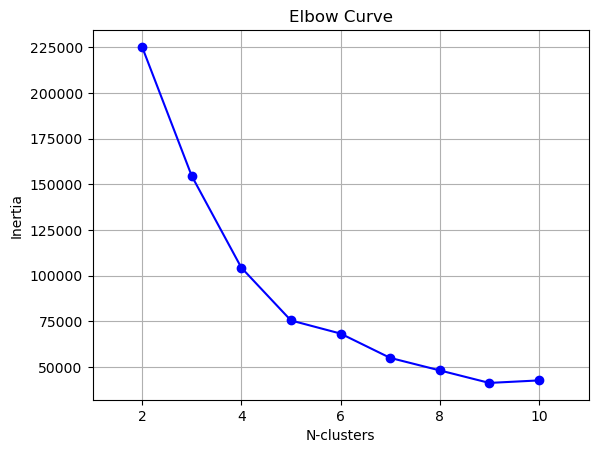

In [124]:
# Visualise inertia
import matplotlib.pyplot as plt
plt.plot(range(2, len(inertias)+2), inertias, marker="o", c="blue")
plt.xlim([1, 11])
plt.grid()
plt.ylabel("Inertia")
plt.xlabel("N-clusters")
plt.title("Elbow Curve")
plt.savefig("./assets/elbow.png")
plt.show()

# END